In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import LogNorm
import sys
import datetime
sys.path.insert(0, '..')
from models import Classifier, WeightedMSE, FlatLoss
from utils import Metrics, find_threshold, DataSet, Logger

np.random.seed(42)

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#device= "cpu"
print('device used in training:', device)

device used in training: cuda:0


# Generating Toy Data
Generate signal mass from a uniform + gaussian distribution.

Generate background mass from a linear distribution $ ax + b $ (with $ a = \frac{1}{4} $ and $ b = \frac{1}{2} $ ) using inversion transform sampling.

Generate random gaussian variables uncorrelated with mass but slightly different for signal and background.

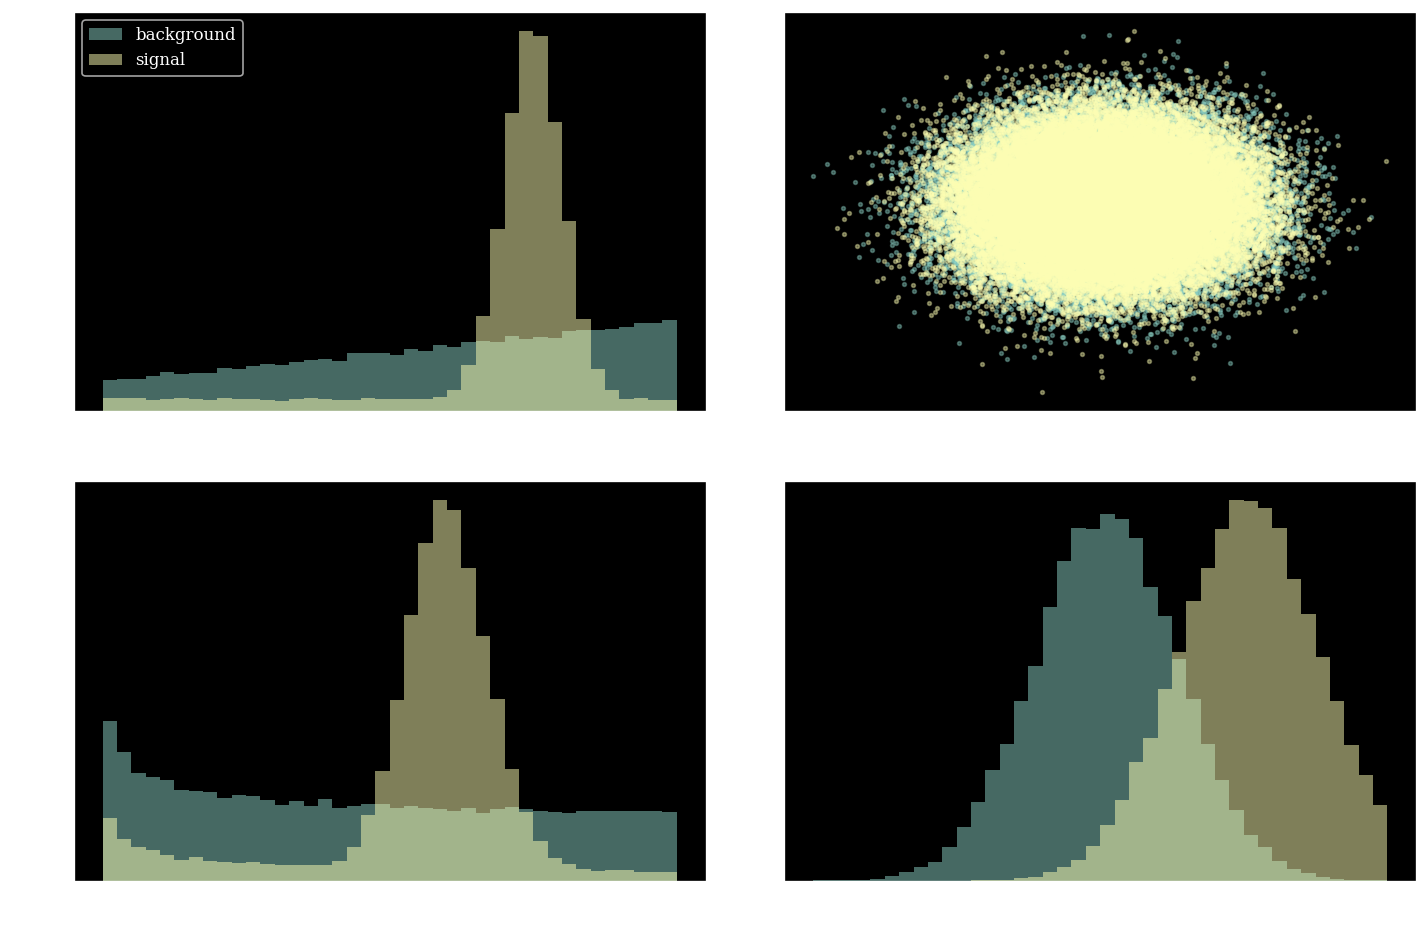

In [8]:
n_s = int(5e4)
n_b = int(5e4)
n_s_gauss_frac = 0.8

a = 1/4 
b = 1/2

u = np.random.uniform(0,1,n_b)
u_ = np.random.uniform(0,1,n_b)

m_b = - b/(a) + np.sqrt((b-a)**2 + 2*a*u)/(a)
m_s = np.concatenate([np.random.uniform(-1,1,n_s-int(n_s_gauss_frac*n_s)), 
                    np.random.normal(0.5,0.1,size=int(n_s_gauss_frac*n_s))])
m_t = -b/(a) + np.sqrt((b-a)**2 + 2*a*u_)/(a)
m_t.sort()

x_b,y_b  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_b).T
x_s,y_s  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_s).T
x_t,y_t  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_b).T


z_b = np.random.normal(-1,1,n_b)
z_s = np.random.normal(1,1,n_s)
z_t = np.random.normal(-1,1,n_b)

fig ,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(12,8),dpi=120)

_,bins,_ = ax1.hist(m_b,bins=40,density=True,alpha=0.5, label='background')
ax1.hist(m_s,bins=bins,density=True,alpha=0.5,label='signal')
ax1.legend()
ax1.set_xlabel(r"$m$")
ax1.set_ylabel("Normed Counts")

ax2.scatter(x_b,y_b,s=5,alpha=0.4)
ax2.scatter(x_s,y_s,s=5,alpha=0.4)
ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$y$")

_,bins,_ = ax3.hist(m_b**2+2.5*m_b,bins=40,density=True,alpha=0.5, label='background')
ax3.hist(m_s**2+2.5*m_s,bins=bins,density=True,alpha=0.5,label='signal')
ax3.set_xlabel(r"$m^2 + 2m$")

_,bins,_ = ax4.hist(z_b,bins=40,density=True,alpha=0.5, label='background')
ax4.hist(z_s,bins=bins,density=True,alpha=0.5,label='signal')
ax4.set_xlabel(r"$z$")

#ax2.set_title("Data")
fig.tight_layout()
#plt.savefig("./plots/Data.pdf")
plt.show()

In [4]:
x = np.concatenate([np.stack([x_s,y_s,z_s],axis=1),
                   np.stack([x_b,y_b,z_b],axis=1)])

y = np.concatenate([np.zeros(m_s.size),np.ones(m_b.size)])

x_test = np.stack([x_t,y_t,z_t],axis=1) 

# Shuffling the data
size = y.size
mask = np.arange(size)
np.random.shuffle(mask)

# Train Validation Split
x_train = x[mask][:int(size*0.8)]
y_train = y[mask][:int(size*0.8)]

x_val = x[mask][int(size*0.8):]
y_val = y[mask][int(size*0.8):]


traindataset = DataSet(x_train.astype('float32'),y_train.astype('int32'),x_train[::,0].astype('float32'))
valdataset = DataSet(x_val.astype('float32'),y_val.astype('int32'),x_val[::,0].astype('float32'))
testTensor= torch.from_numpy(x_test).float().to(device)

In [5]:
my_cmap = get_cmap('viridis')
my_cmap.set_bad(my_cmap.colors[0])
now = datetime.datetime.now().strftime("%m-%d_%H-%M")

params = {'epochs'       : 300,
          'interval'     : 100,
          'batch_size'   : 4096,
          'shuffle'      : True,
          'num_workers'  : 6,
          'drop_last'    : False,
          'device'       : device,
          'pass_x_biased': True,
         }
logger = Logger(f"./log/logTest({now}).txt",overwrite=False)

Entering Training...
Epoch:0001/0300  (0.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.2484, acc:53%, R50: 2.6576, 1/JSD: 2213.0977
Epoch:0100/0300  (87.9 s)
 Train: loss:0.0180, acc:98% || Val: loss: 0.0167, acc:98%, R50: inf, 1/JSD: nan


../utils.py:259: RuntimeWarning: divide by zero encountered in double_scalars
  R50 = 1/((preds[targets==1]<c).sum()/(targets==1).sum())
/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Epoch:0200/0300  (163.9s)
 Train: loss:0.0187, acc:97% || Val: loss: 0.0166, acc:98%, R50: inf, 1/JSD: nan
Epoch:0300/0300  (248.1s)
 Train: loss:0.0203, acc:97% || Val: loss: 0.0166, acc:98%, R50: inf, 1/JSD: nan


/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


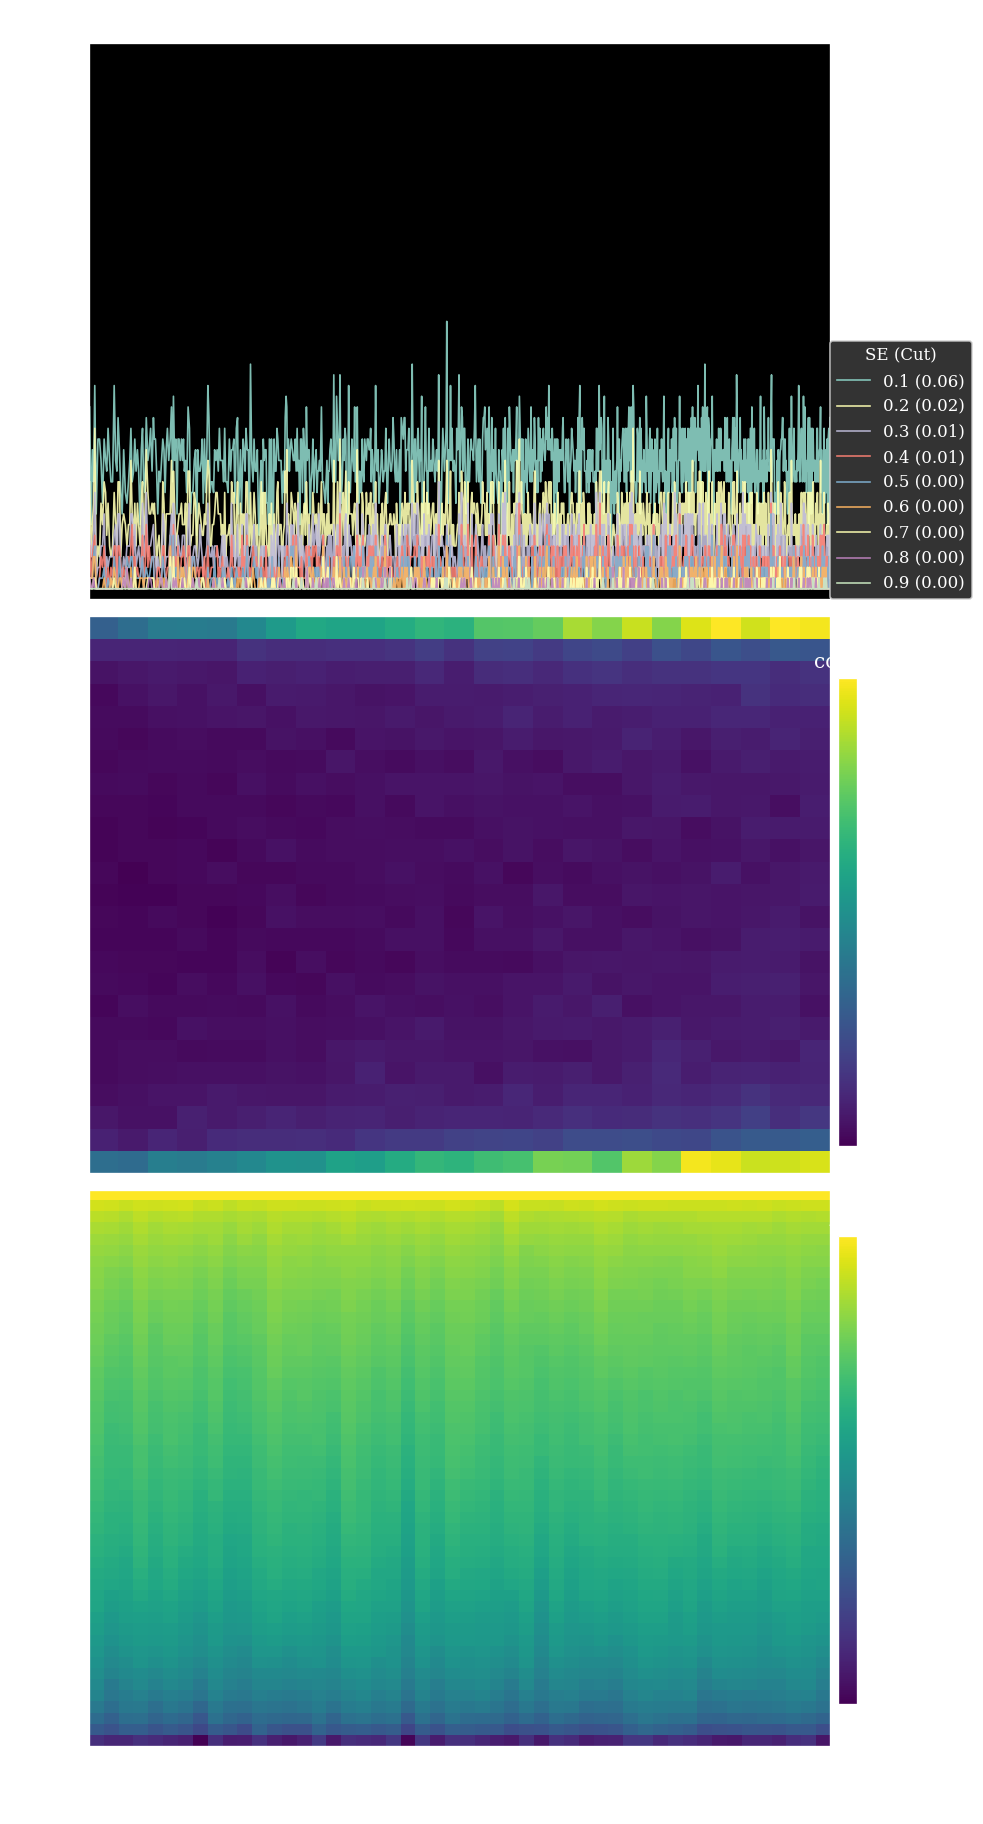

Entering Training...
Epoch:0001/0300  (0.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.2565, acc:49%, R50: 1.0544, 1/JSD: 17829.5452
Epoch:0100/0300  (74.4 s)
 Train: loss:0.0194, acc:97% || Val: loss: 0.0185, acc:98%, R50: 10043.0000, 1/JSD: 260.8065
Epoch:0200/0300  (152.7s)
 Train: loss:0.0197, acc:98% || Val: loss: 0.0186, acc:98%, R50: 10043.0000, 1/JSD: 260.8065
Epoch:0300/0300  (225.8s)
 Train: loss:0.0203, acc:98% || Val: loss: 0.0186, acc:98%, R50: 10043.0000, 1/JSD: 260.8065


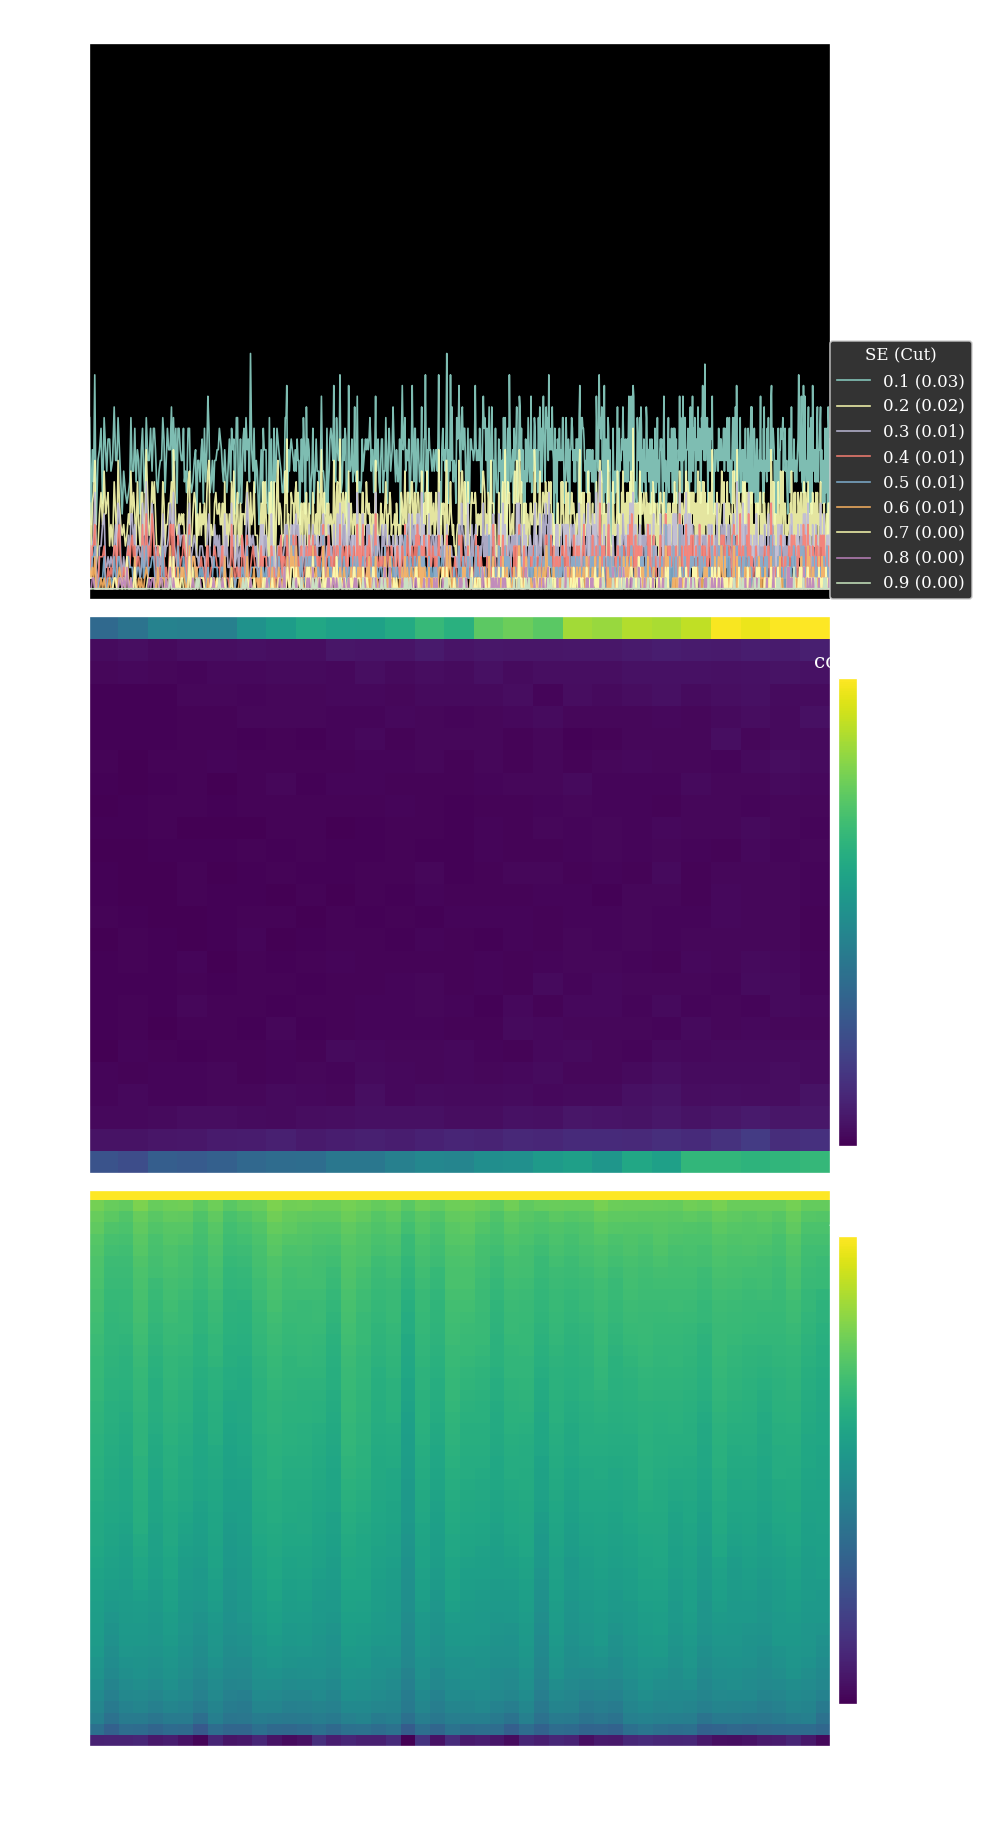

Entering Training...
Epoch:0001/0300  (0.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.2431, acc:73%, R50: 436.6522, 1/JSD: 411.1615
Epoch:0100/0300  (76.8 s)
 Train: loss:0.0264, acc:97% || Val: loss: 0.0205, acc:97%, R50: 5021.5000, 1/JSD: 407.5487
Epoch:0200/0300  (155.2s)
 Train: loss:0.0222, acc:98% || Val: loss: 0.0207, acc:97%, R50: 5021.5000, 1/JSD: 407.5487
Epoch:0300/0300  (231.6s)
 Train: loss:0.0236, acc:98% || Val: loss: 0.0206, acc:97%, R50: 5021.5000, 1/JSD: 407.5487


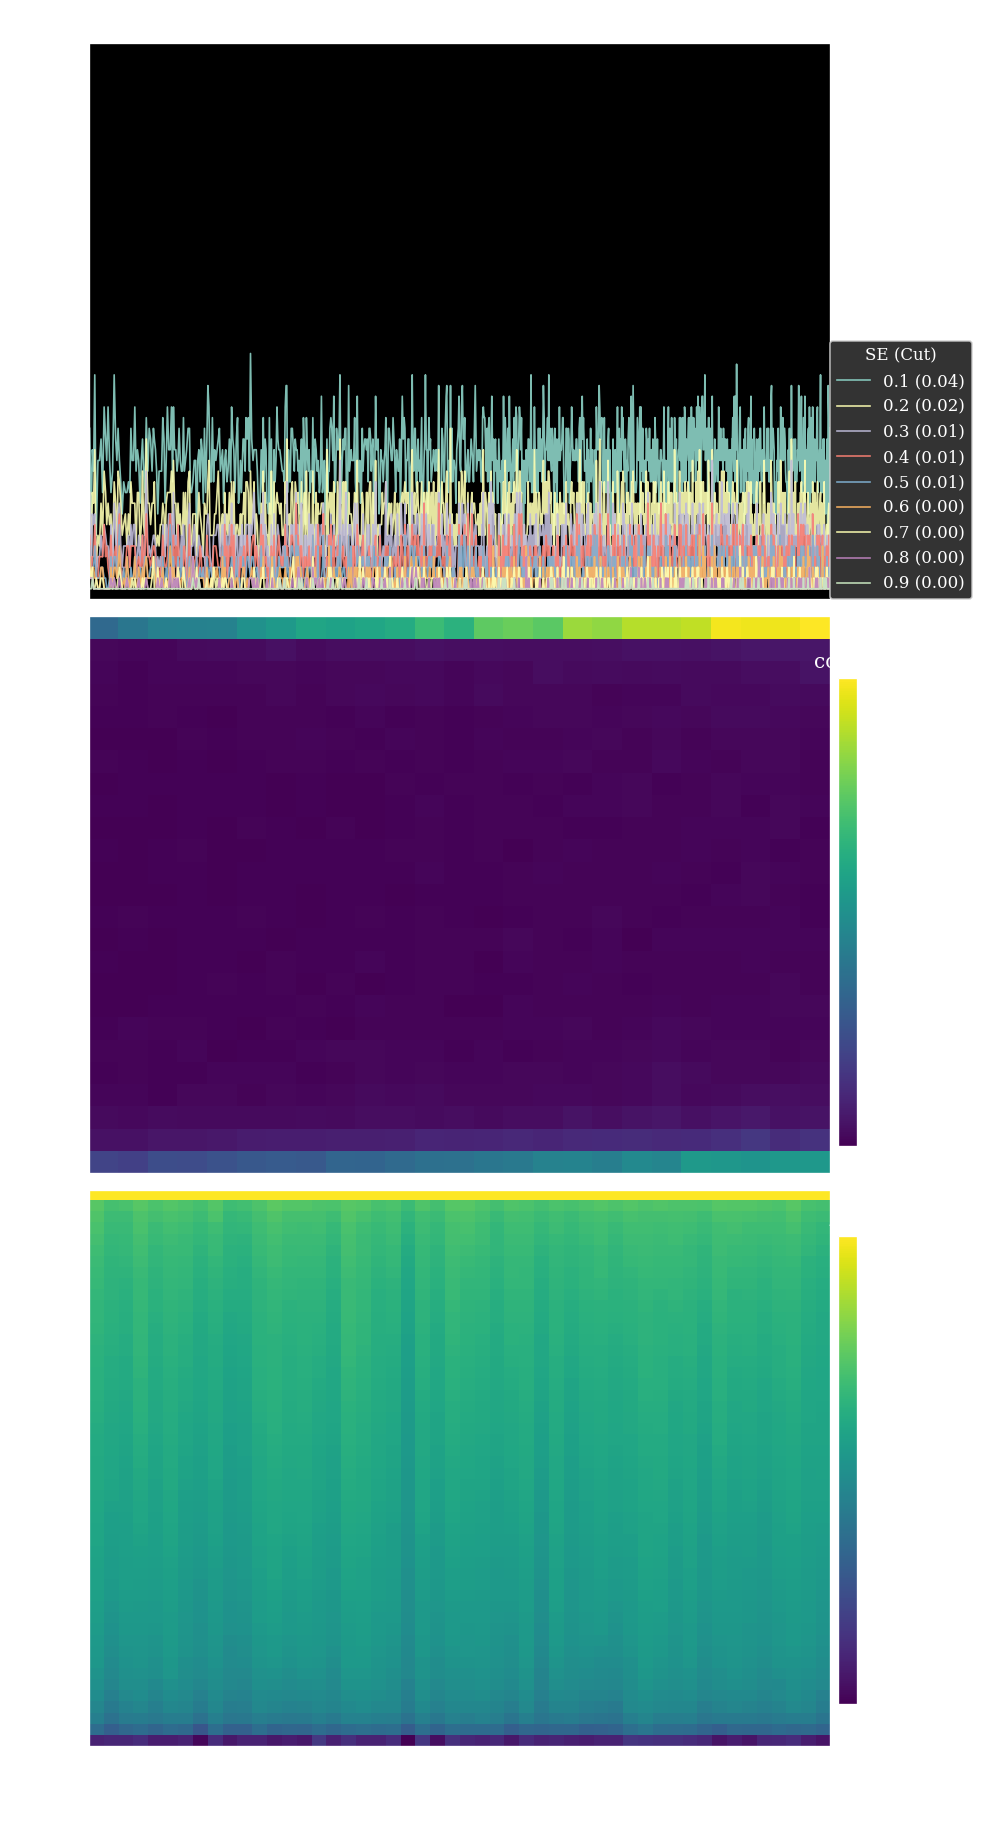

Entering Training...
Epoch:0001/0300  (0.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.2494, acc:53%, R50: 3.7558, 1/JSD: 618.2801
Epoch:0100/0300  (90.0 s)
 Train: loss:0.0240, acc:97% || Val: loss: 0.0219, acc:97%, R50: 10043.0000, 1/JSD: 260.8065
Epoch:0200/0300  (166.0s)
 Train: loss:0.0257, acc:97% || Val: loss: 0.0218, acc:97%, R50: 10043.0000, 1/JSD: 260.8065
Epoch:0300/0300  (250.4s)
 Train: loss:0.0261, acc:97% || Val: loss: 0.0219, acc:97%, R50: 10043.0000, 1/JSD: 260.8065


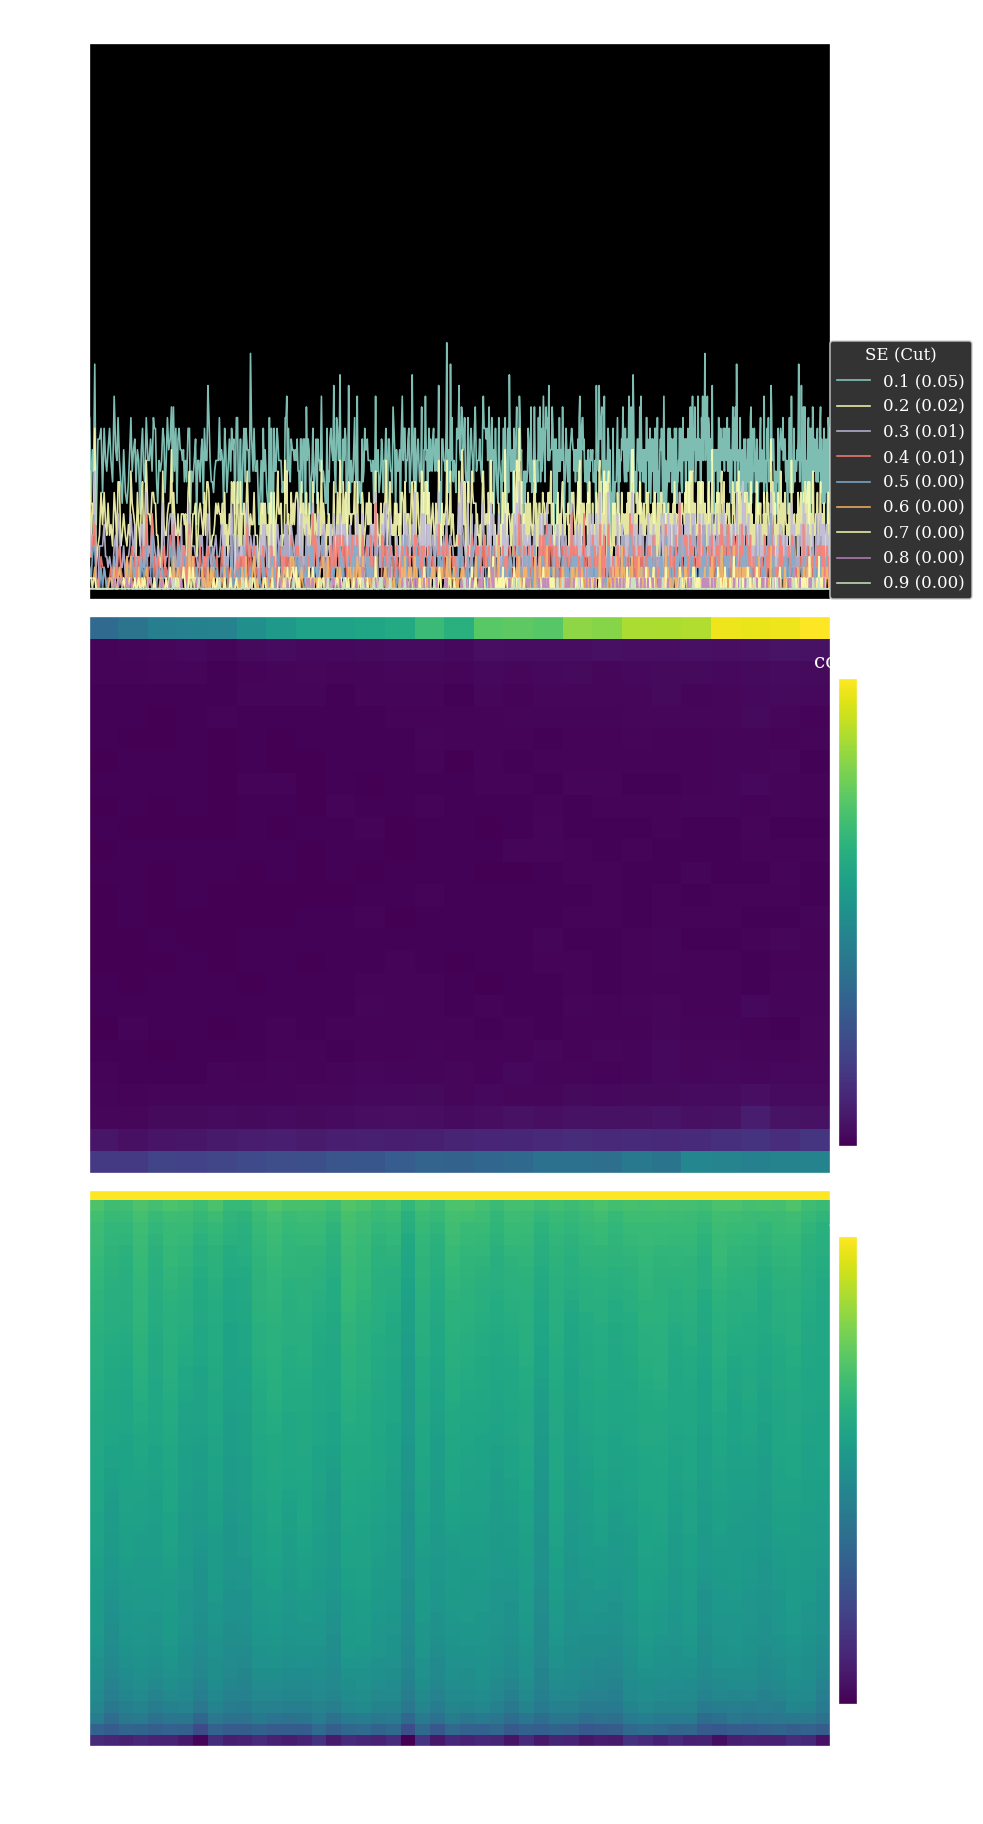

Entering Training...
Epoch:0001/0300  (0.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.2493, acc:53%, R50: 2.4229, 1/JSD: 656.6901
Epoch:0100/0300  (78.0 s)
 Train: loss:0.0273, acc:97% || Val: loss: 0.0245, acc:97%, R50: 10043.0000, 1/JSD: 260.8065
Epoch:0200/0300  (164.2s)
 Train: loss:0.0250, acc:98% || Val: loss: 0.0246, acc:97%, R50: 10043.0000, 1/JSD: 260.8065
Epoch:0300/0300  (242.2s)
 Train: loss:0.0264, acc:97% || Val: loss: 0.0246, acc:97%, R50: 10043.0000, 1/JSD: 260.8065


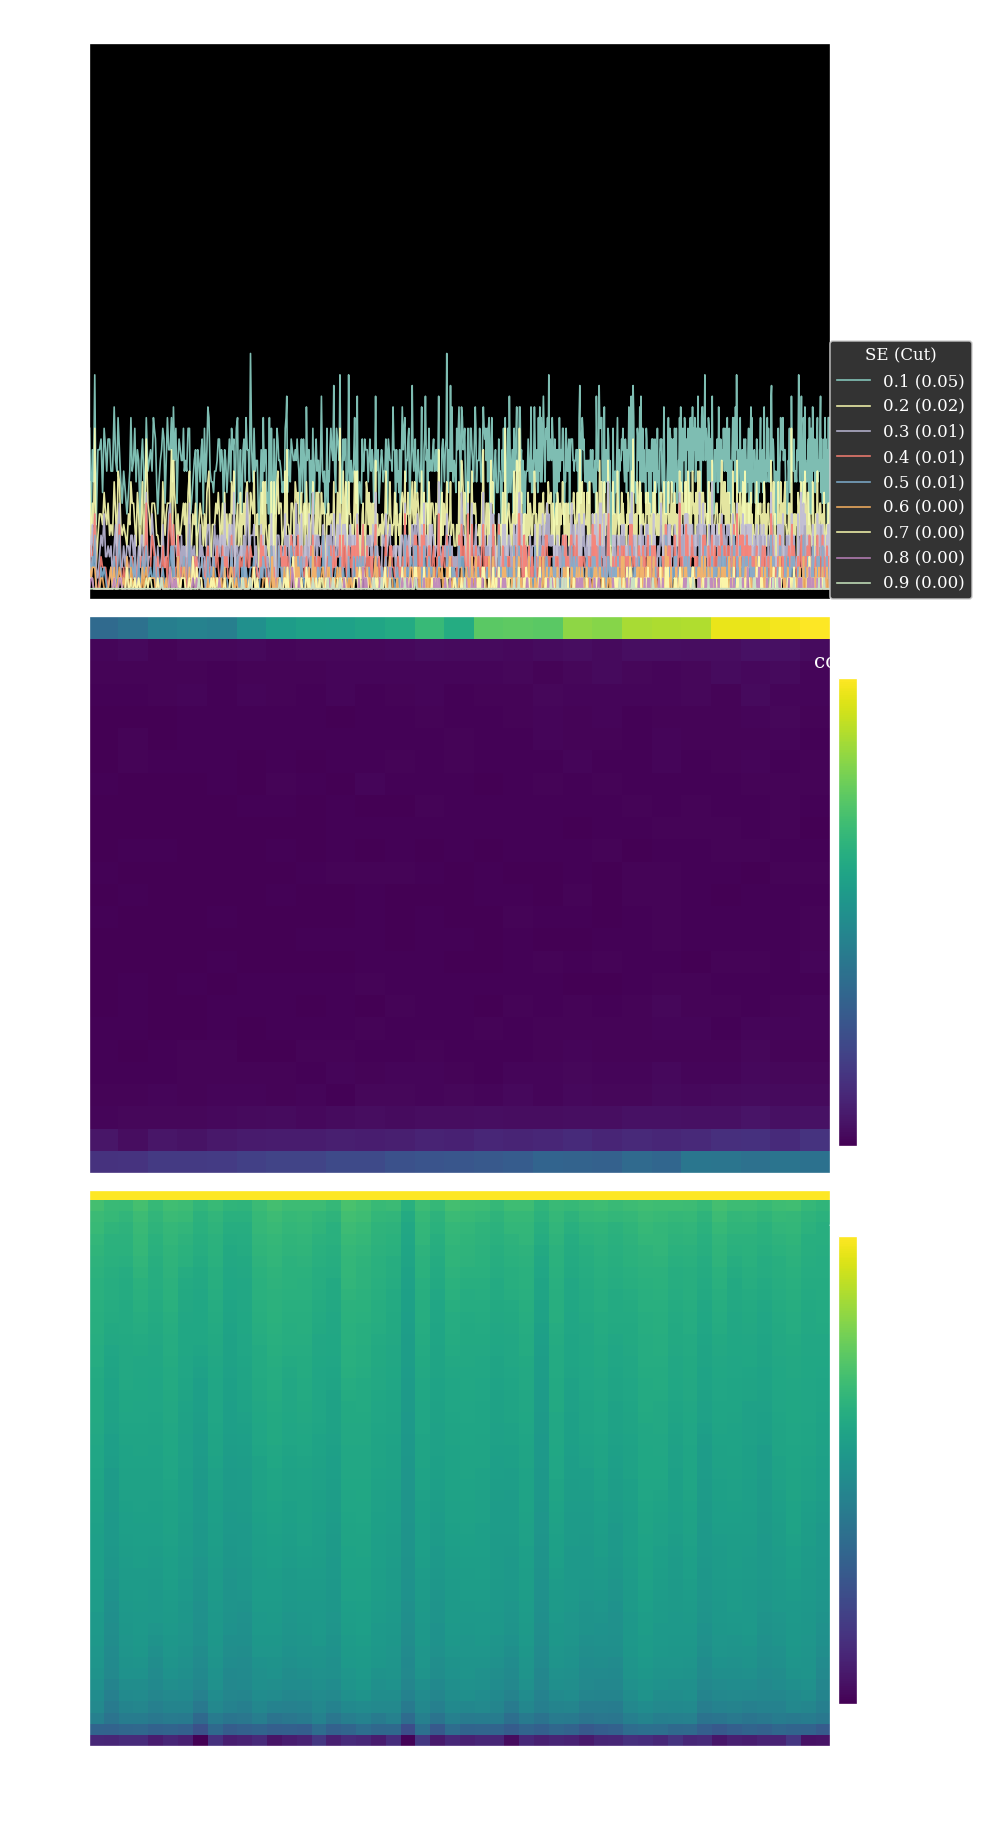

Entering Training...
Epoch:0001/0300  (0.3  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.2484, acc:48%, R50: 8.9670, 1/JSD: 589.3639
Epoch:0100/0300  (82.6 s)
 Train: loss:0.4865, acc:51% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan
Epoch:0200/0300  (148.8s)
 Train: loss:0.4993, acc:50% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan
Epoch:0300/0300  (218.4s)
 Train: loss:0.5185, acc:48% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan


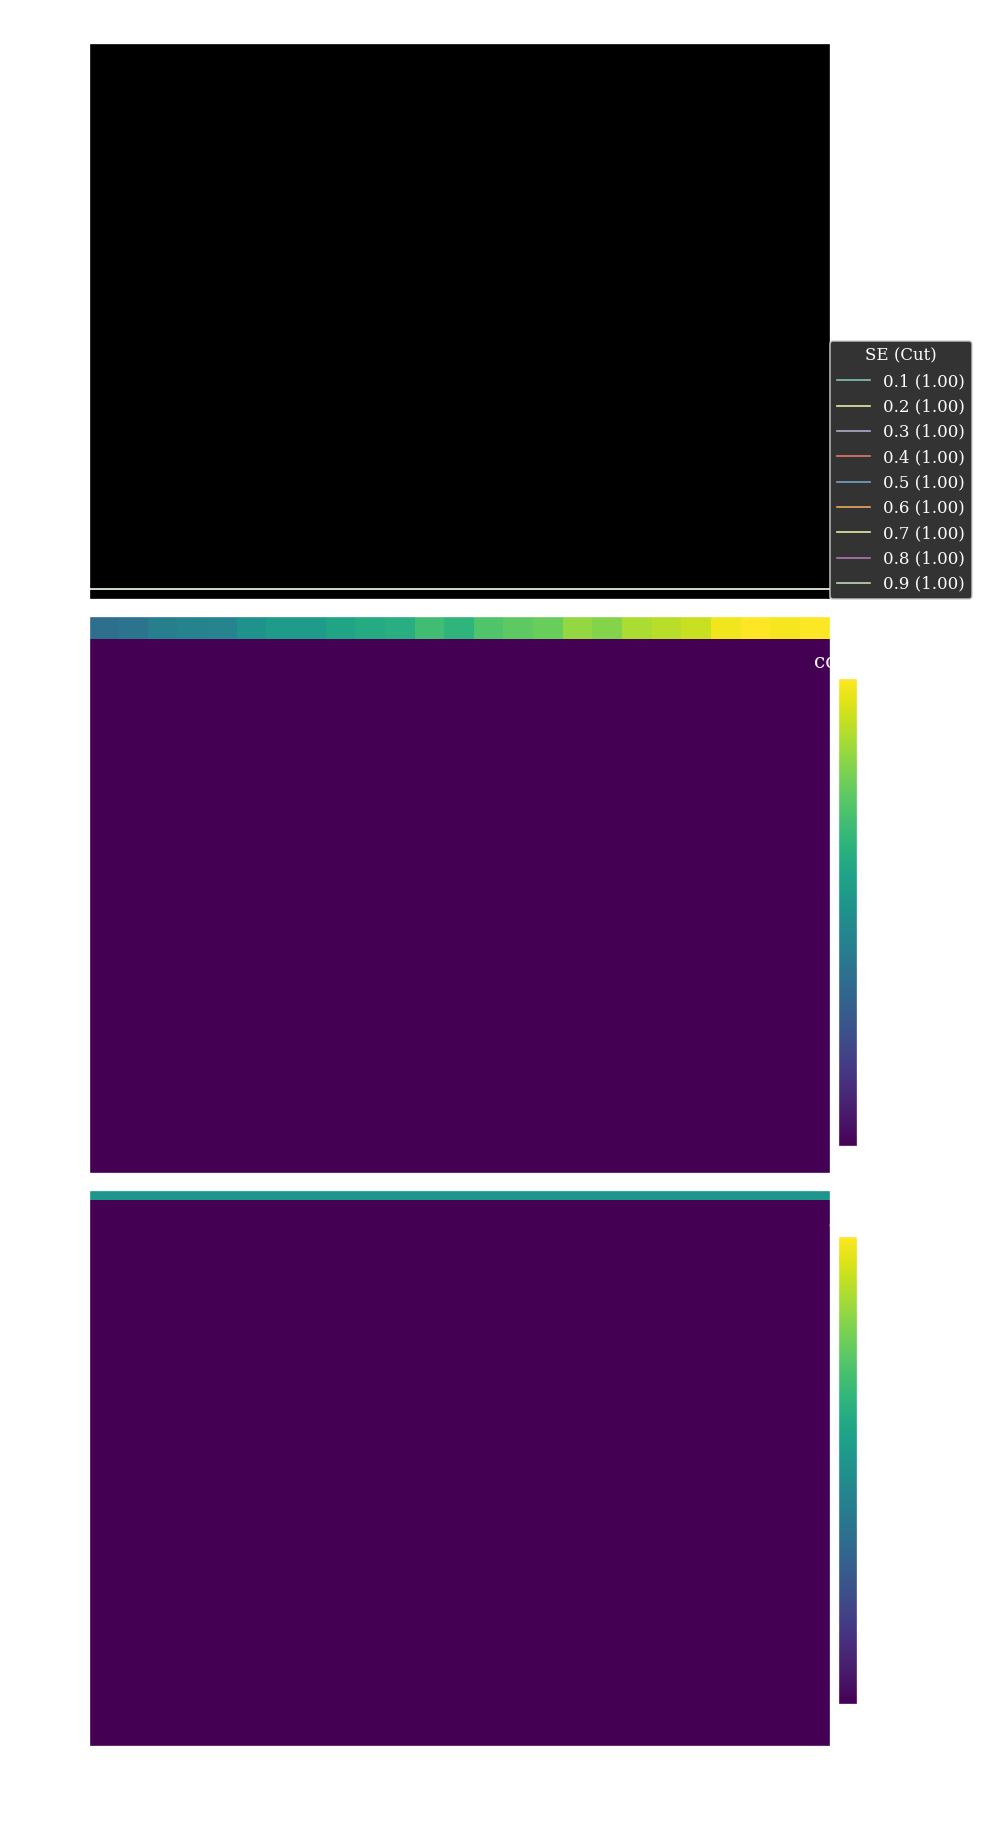

Entering Training...
Epoch:0001/0300  (0.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.2502, acc:49%, R50: 1.9604, 1/JSD: 2056.7152
Epoch:0100/0300  (84.4 s)
 Train: loss:0.5105, acc:48% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan
Epoch:0200/0300  (159.8s)
 Train: loss:0.4978, acc:50% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan
Epoch:0300/0300  (235.4s)
 Train: loss:0.4969, acc:50% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan


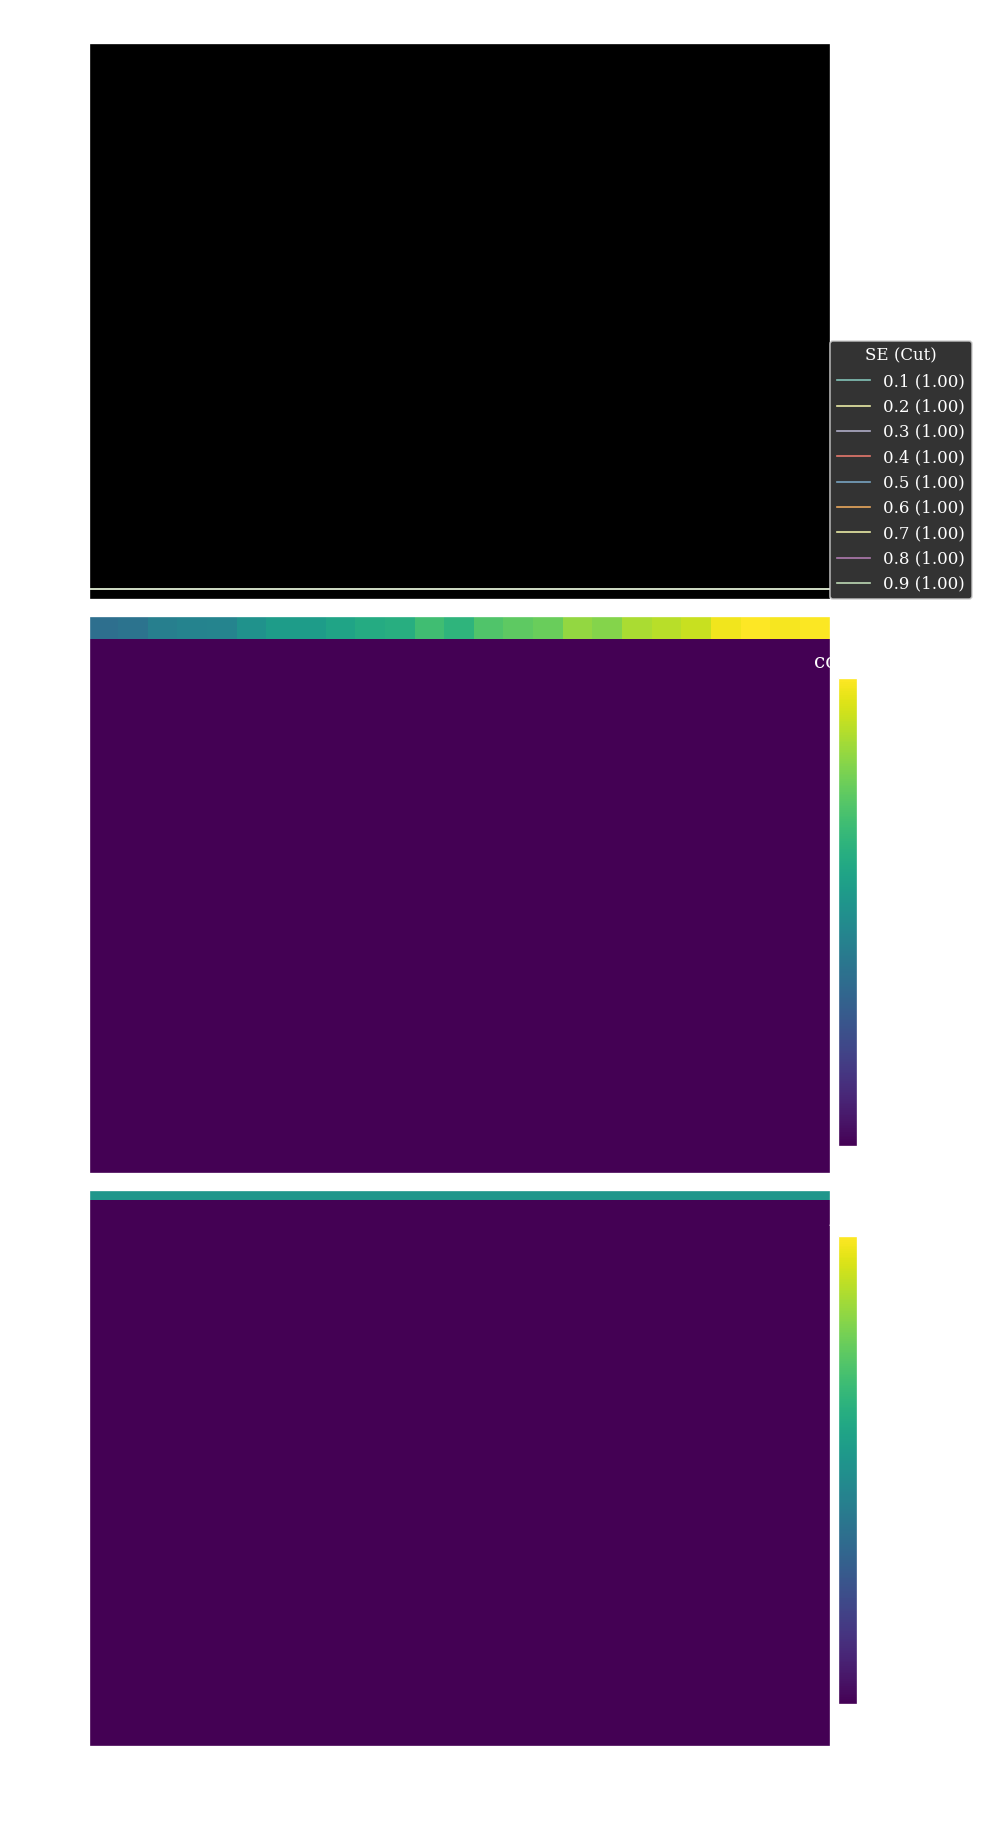

Entering Training...
Epoch:0001/0300  (0.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.2526, acc:50%, R50: 1.2397, 1/JSD: 15745.6908
Epoch:0100/0300  (84.0 s)
 Train: loss:0.4666, acc:51% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan
Epoch:0200/0300  (156.9s)
 Train: loss:0.4854, acc:49% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan
Epoch:0300/0300  (226.6s)
 Train: loss:0.4849, acc:49% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan


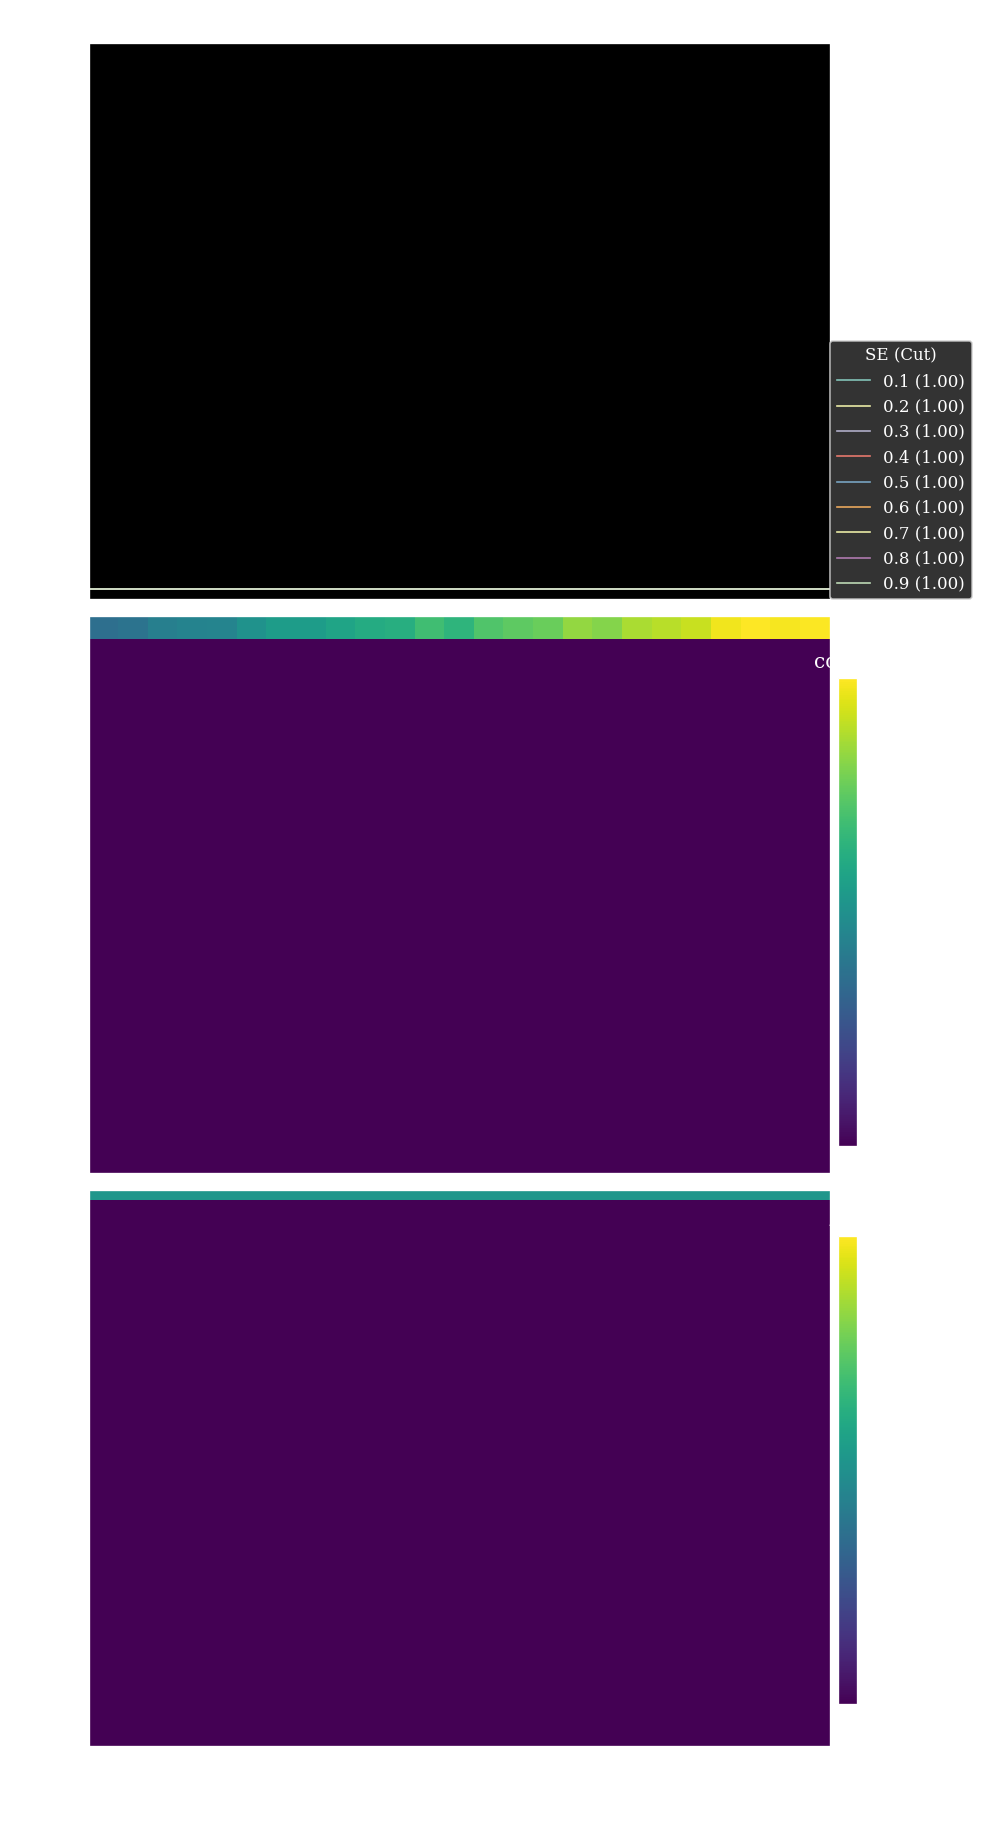

Entering Training...
Epoch:0001/0300  (0.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.2536, acc:50%, R50: 1.0359, 1/JSD: 1386754.5605
Epoch:0100/0300  (80.2 s)
 Train: loss:0.4604, acc:49% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan
Epoch:0200/0300  (156.3s)
 Train: loss:0.4479, acc:51% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan
Epoch:0300/0300  (231.6s)
 Train: loss:0.4583, acc:50% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan


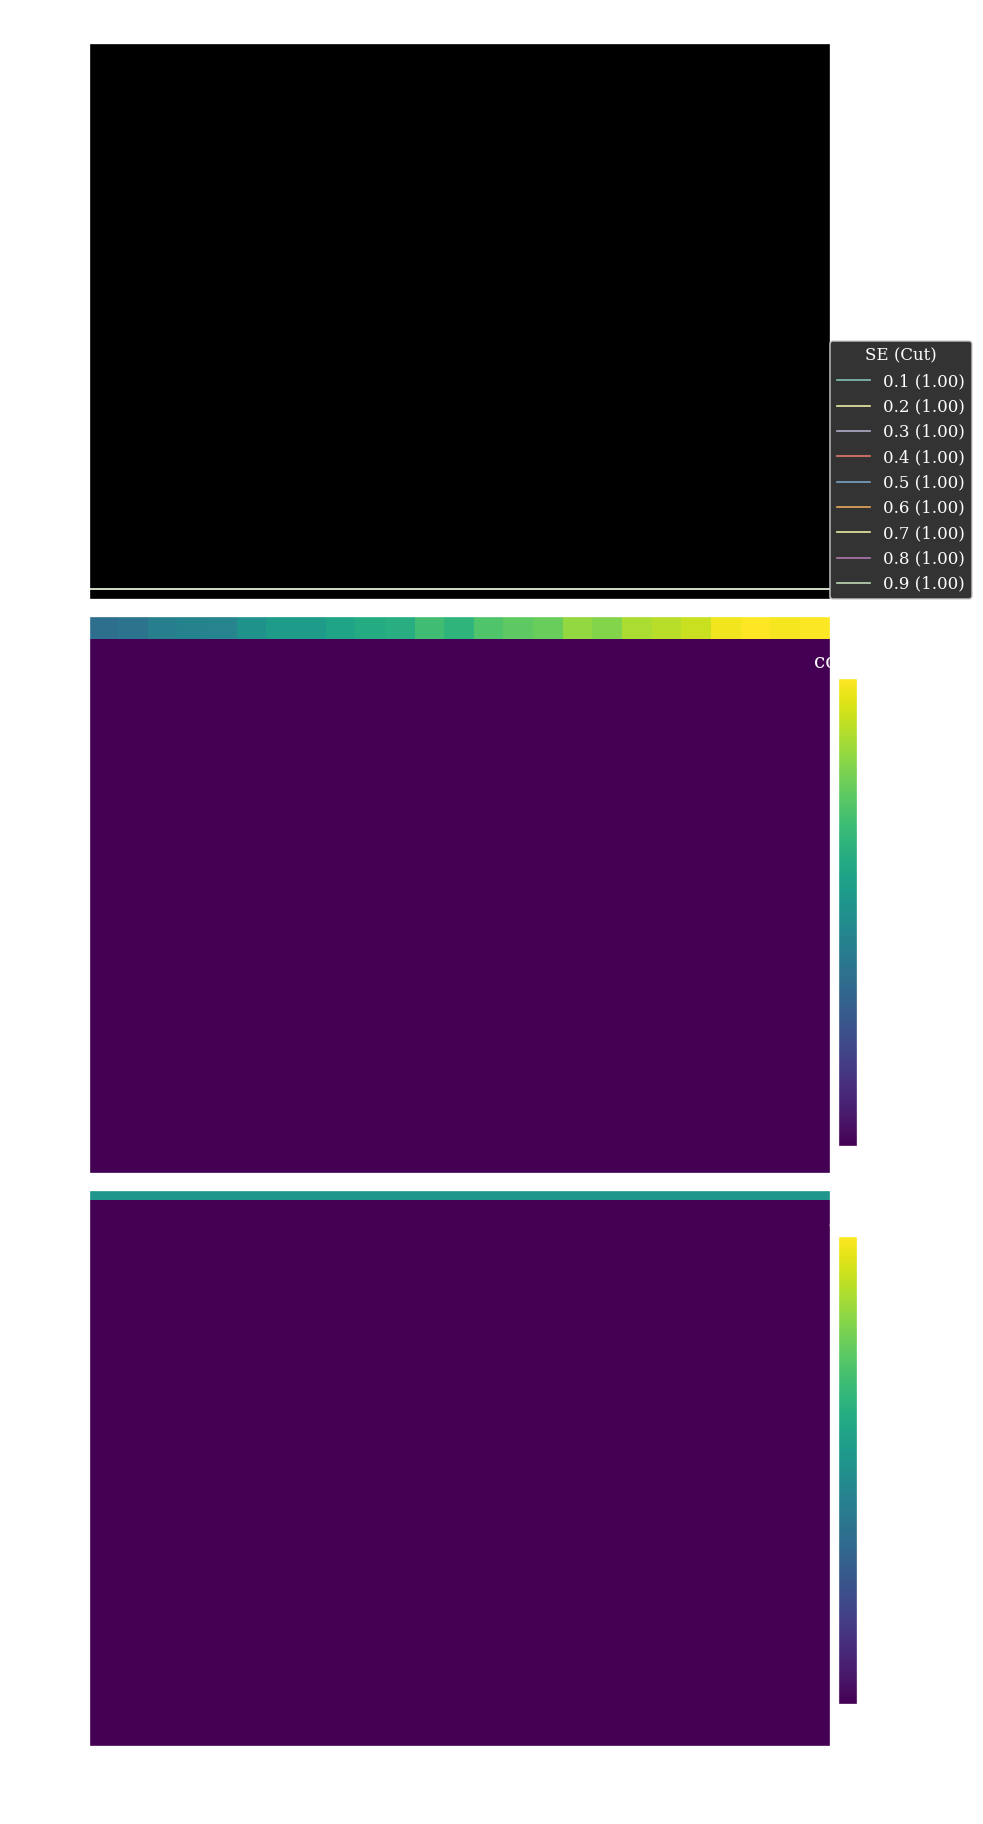

Entering Training...
Epoch:0001/0300  (0.3  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.2500, acc:52%, R50: 1.4627, 1/JSD: 41057.0312
Epoch:0100/0300  (83.7 s)
 Train: loss:0.3355, acc:50% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan
Epoch:0200/0300  (157.2s)
 Train: loss:0.3395, acc:49% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan
Epoch:0300/0300  (232.2s)
 Train: loss:0.3312, acc:50% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan


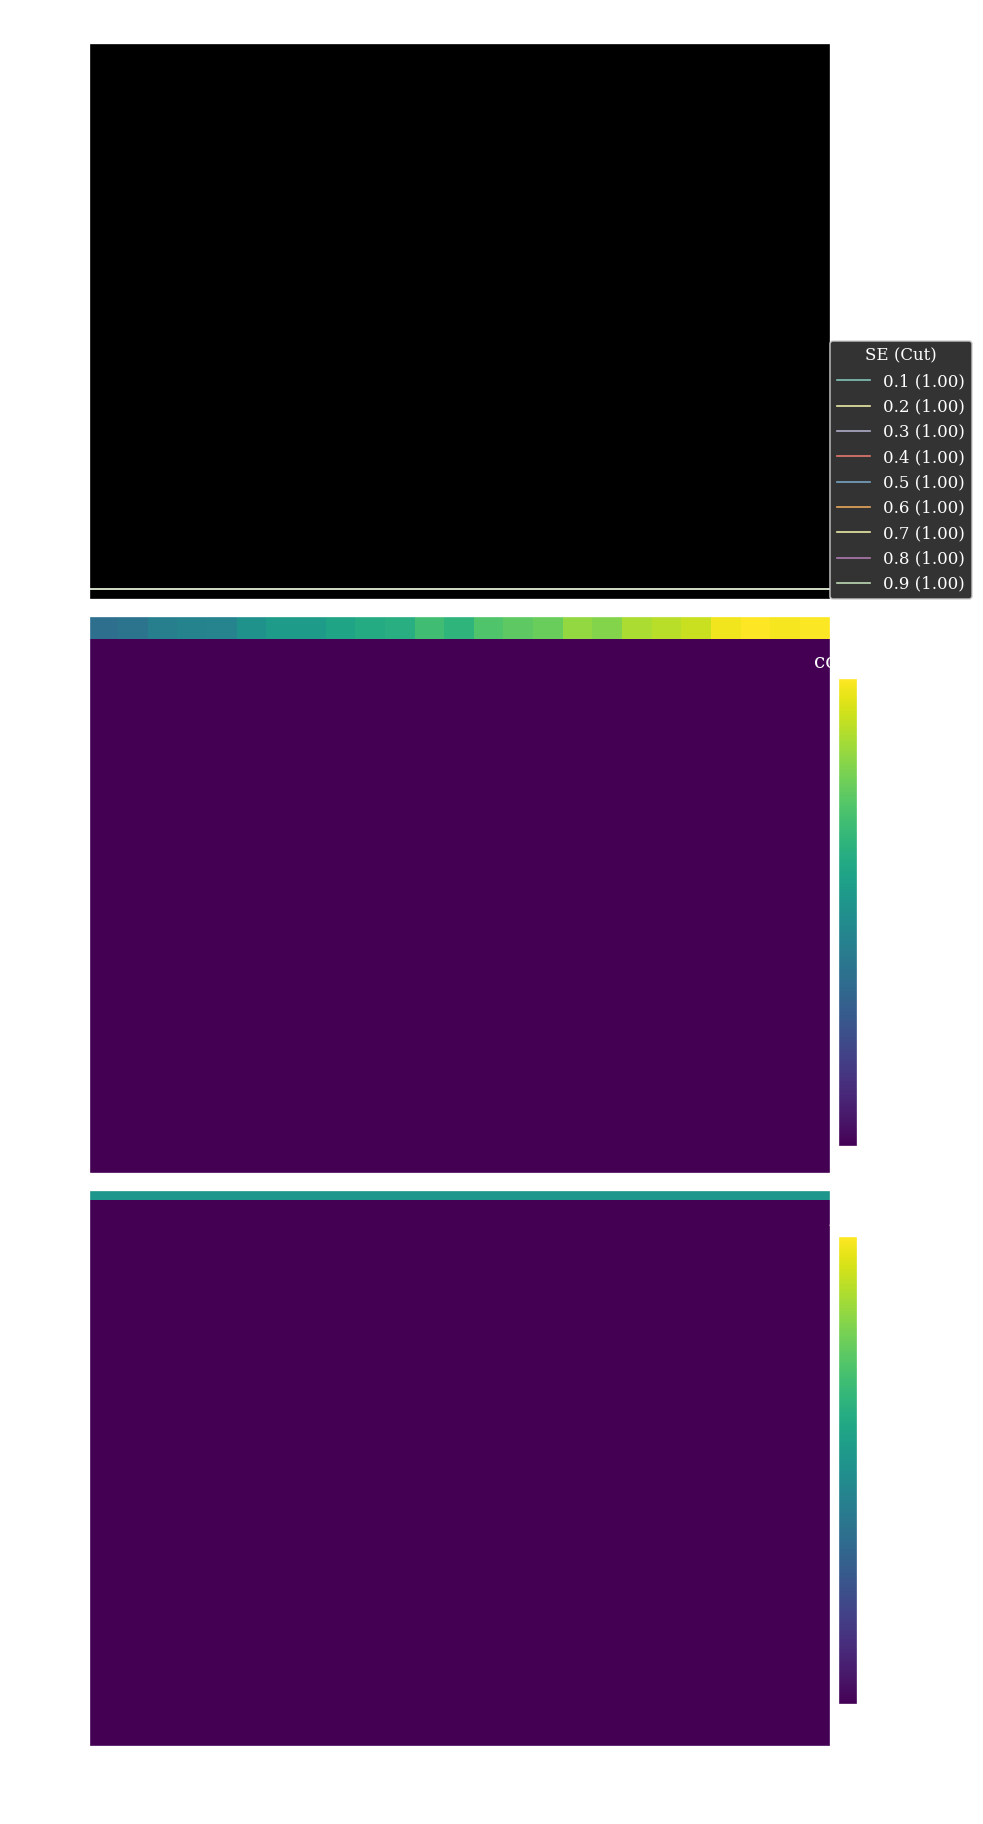

In [7]:
# torch.manual_seed(69)
# efficiencies = np.linspace(0.1,0.9,9)
# for i,strength in enumerate([0,1e-4,3e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1]):
#     lr=1e-1
#     frac = strength/(1+strength)
#     metrics_train_legendre = Metrics()
#     metrics_val_legendre = Metrics(validation=True)
#     model_legendre = Classifier(input_size=3).to(device)
#     model_legendre.loss = FlatLoss(frac=frac,labels=y_train,bins=128,order=1,
#                                    background_only=True,norm='L2',recalculate=True)
#     model_legendre.fit(traindataset=traindataset,
#                        valdataset=valdataset,
#                        **params,
#                        optimizer=torch.optim.SGD(model_legendre.parameters(),lr=lr,momentum=0.),
#                        log=logger,
#                        #scheduler=scheduler,
#                        metrics=[metrics_train_legendre,metrics_val_legendre])
    
#     validation_predictions = np.array(model_legendre.yhat_val.tolist()).flatten()
#     cuts = []
#     for eff in efficiencies:
#         cuts.append(find_threshold(validation_predictions,(y_val==0),eff))
    
#     bins = 50
#     scores = np.array(model_legendre(testTensor).tolist()).reshape(-1,bins)
#     m = m_t.reshape(-1,bins).mean(axis=1)
#     F_s = []
#     for s in scores.reshape(50,-1):
#         density = np.histogram(s,bins=50,range=(0,1))[0]
#         F_s.append(np.cumsum(density)/density.sum())
#     F_s = np.array(F_s).T
#     fig, [ax1, ax2, ax3]  = plt.subplots(3,1,figsize=[8,5*3],dpi=120,sharex=True)
#     for j,cut in enumerate(cuts):
#         c = f"C{j}" if j!= 6 else f"C11"
#         passed = (scores<cut).sum(axis=1)/scores.shape[1]
#         ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)

#     ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=17)
#     ax1.set_ylim([-0.02,1.02])
#     ax1.set_title("(strength: {:.02e}, acc: {:.02})".format(strength, metrics_val_legendre.accs[-1]),fontsize=17)
#     ax1.legend(loc=(1,0),markerscale=5,title="SE (Cut)",ncol=1)

#     _,_,_,h = ax2.hist2d(m_t,scores.flatten(),bins=25, label="all",cmap='viridis',range=[[-1,1],[0,1]])
#     cbaxes = fig.add_axes([0.86, 0.37, 0.02, 0.26]) 
#     cb = plt.colorbar(h,ax=ax2,cax = cbaxes)
#     cb.ax.set_title("counts")
#     ax2.set_ylabel(r"$s$",fontsize=17)

#     im = ax3.imshow(F_s,label="all",origin='lower',extent=[-1,1,0,1],aspect="auto",norm=LogNorm(),cmap=my_cmap)
#     ax3.set_ylabel(r"$s$",fontsize=17)

#     cbaxes = fig.add_axes([0.86, 0.06, 0.02, 0.26]) 
#     cb = plt.colorbar(im,ax=ax3,cax = cbaxes)
#     cb.ax.set_title(r"$F(s)$")
#     ax3.set_xlabel(r"$m$",fontsize=19)

#     fig.tight_layout(pad=0)
#     plt.show()

In [19]:
params = {'epochs'       : 300,
          'interval'     : 100,
          'batch_size'   : 4096,
          'shuffle'      : True,
          'num_workers'  : 6,
          'drop_last'    : False,
          'device'       : device,
          'pass_x_biased': True,
         }

Entering Training...
Epoch:0001/0300  (0.3  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.2484, acc:53%, R50: 2.6576, 1/JSD: 2213.0977
Epoch:0100/0300  (65.7 s)
 Train: loss:0.0311, acc:97% || Val: loss: 0.0244, acc:97%, R50: 10043.0000, 1/JSD: 260.8065
Epoch:0200/0300  (118.9s)
 Train: loss:0.0304, acc:97% || Val: loss: 0.0244, acc:97%, R50: 10043.0000, 1/JSD: 260.8065
Epoch:0300/0300  (182.8s)
 Train: loss:0.0300, acc:97% || Val: loss: 0.0245, acc:97%, R50: 10043.0000, 1/JSD: 260.8065


/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


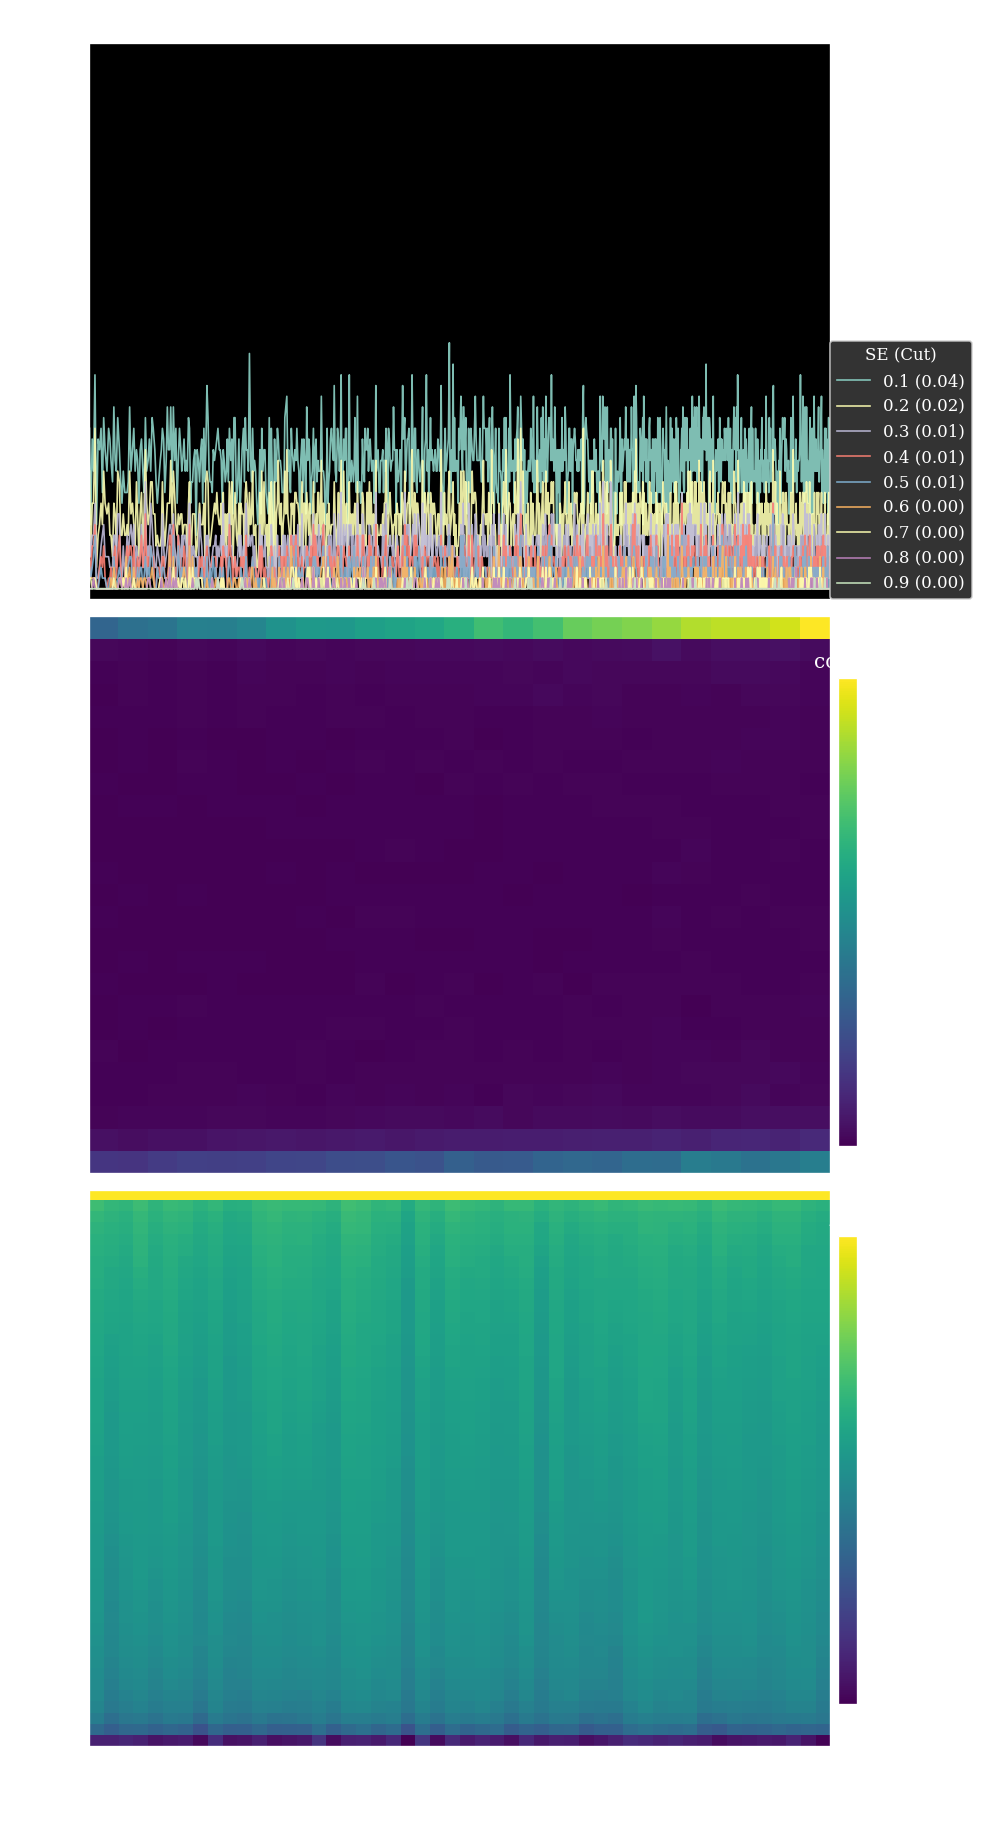

Entering Training...
Epoch:0001/0300  (0.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.2565, acc:49%, R50: 1.0544, 1/JSD: 17829.5452


In [ ]:
torch.manual_seed(69)
efficiencies = np.linspace(0.1,0.9,9)
for i,strength in enumerate([0,1e-4,3e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1][4:6]):
    for lr in [1e-1,1e-2,1e-3]:
        frac = strength/(1+strength)
        metrics_train_legendre = Metrics()
        metrics_val_legendre = Metrics(validation=True)
        model_legendre = Classifier(input_size=3).to(device)
        model_legendre.loss = FlatLoss(frac=frac,labels=y_train,bins=128,order=1,
                                       background_only=True,norm='L2',recalculate=True)
        model_legendre.fit(traindataset=traindataset,
                           valdataset=valdataset,
                           **params,
                           optimizer=torch.optim.SGD(model_legendre.parameters(),lr=lr,momentum=0.),
                           log=logger,
                           #scheduler=scheduler,
                           metrics=[metrics_train_legendre,metrics_val_legendre])

        validation_predictions = np.array(model_legendre.yhat_val.tolist()).flatten()
        cuts = []
        for eff in efficiencies:
            cuts.append(find_threshold(validation_predictions,(y_val==0),eff))

        bins = 50
        scores = np.array(model_legendre(testTensor).tolist()).reshape(-1,bins)
        m = m_t.reshape(-1,bins).mean(axis=1)
        F_s = []
        for s in scores.reshape(50,-1):
            density = np.histogram(s,bins=50,range=(0,1))[0]
            F_s.append(np.cumsum(density)/density.sum())
        F_s = np.array(F_s).T
        fig, [ax1, ax2, ax3]  = plt.subplots(3,1,figsize=[8,5*3],dpi=120,sharex=True)
        for j,cut in enumerate(cuts):
            c = f"C{j}" if j!= 6 else f"C11"
            passed = (scores<cut).sum(axis=1)/scores.shape[1]
            ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)

        ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=17)
        ax1.set_ylim([-0.02,1.02])
        ax1.set_title("(strength: {:.02e}, acc: {:.02})".format(strength, metrics_val_legendre.accs[-1]),fontsize=17)
        ax1.legend(loc=(1,0),markerscale=5,title="SE (Cut)",ncol=1)

        _,_,_,h = ax2.hist2d(m_t,scores.flatten(),bins=25, label="all",cmap='viridis',range=[[-1,1],[0,1]])
        cbaxes = fig.add_axes([0.86, 0.37, 0.02, 0.26]) 
        cb = plt.colorbar(h,ax=ax2,cax = cbaxes)
        cb.ax.set_title("counts")
        ax2.set_ylabel(r"$s$",fontsize=17)

        im = ax3.imshow(F_s,label="all",origin='lower',extent=[-1,1,0,1],aspect="auto",norm=LogNorm(),cmap=my_cmap)
        ax3.set_ylabel(r"$s$",fontsize=17)

        cbaxes = fig.add_axes([0.86, 0.06, 0.02, 0.26]) 
        cb = plt.colorbar(im,ax=ax3,cax = cbaxes)
        cb.ax.set_title(r"$F(s)$")
        ax3.set_xlabel(r"$m$",fontsize=19)

        fig.tight_layout(pad=0)
        plt.show()

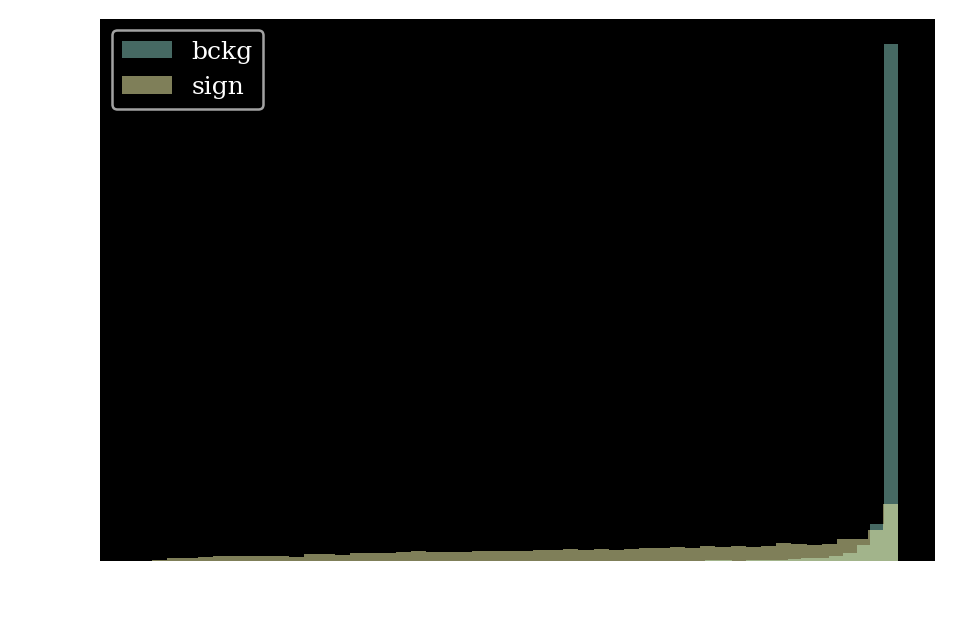

In [50]:
plt.subplots(1,1,figsize=(6,4),dpi=180)
plt.hist(np.array(model_legendre.yhat_val.tolist())[y_val==1],bins=50,label='bckg',alpha=0.5)
plt.hist(np.array(model_legendre.yhat_val.tolist())[y_val==0],bins=50,label='sign',alpha=0.5)
plt.legend()
plt.show()